## ***Facial Expression Recognition***
# *ResNet50 vs Our CNN*

In [ ]:
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import f1_score

In [ ]:
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/fer2013.csv')

print('Dataframe shape:' + str(df.shape))

#0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4:'sadness', 5:'surprise', 6:'neutral'
print('Unique labels with count:' + str(df.emotion.value_counts()))

Dataframe shape:(35887, 3)
Unique labels with count:3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [ ]:
df_train = df[df.Usage.isin(['Training','PublicTest'])]
print('Training and Validation Dataframe shape:' + str(df_train.shape))
df_test = df[df.Usage.isin(['PrivateTest'])]
print('Test Dataframe shape:' + str(df_test.shape))

Training and Validation Dataframe shape:(32298, 3)
Test Dataframe shape:(3589, 3)


In [ ]:
print('_______Training and Validation Data_______')
train_val_img_array = df_train.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
train_val_img_array = np.stack(train_val_img_array, axis=0)
#train_val_img_array = np.repeat(train_val_img_array[..., np.newaxis], 3, -1)
train_val_img_array = np.repeat(train_val_img_array[...], 3, -1)
print('Shape(Training and Validation) after formatting: ' + str(train_val_img_array.shape))

print('_______Test Data_______')
test_img_array = df_test.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
test_img_array = np.stack(test_img_array, axis=0)
test_img_array = np.repeat(test_img_array[...], 3, -1)
print('Shape(Test) after formatting: ' + str(test_img_array.shape))

_______Training and Validation Data_______
Shape(Training and Validation) after formatting: (32298, 48, 48, 3)
_______Test Data_______
Shape(Test) after formatting: (3589, 48, 48, 3)


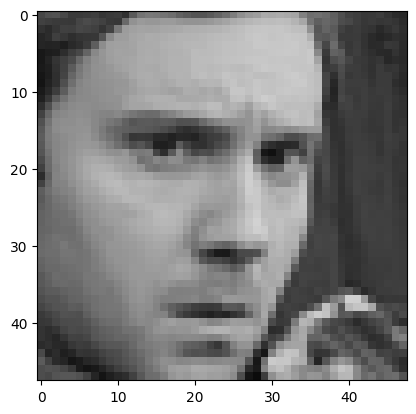

In [ ]:
#plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
plt.imshow(img_array/255.0)

In [ ]:
print('____________________Training and Validation Labels____________________')
train_val_img_labels = k.utils.to_categorical(df_train.emotion)
print('Training Label shape after one-hot encoding: ' + str(train_val_img_labels.shape))
print('Training Sample label: ' + str(train_val_img_labels[0]))

print('____________________Test Labels____________________')
test_img_labels = k.utils.to_categorical(df_test.emotion)
print('Training Label shape after one-hot encoding: ' + str(test_img_labels.shape))
print('Training Sample label: ' + str(test_img_labels[50]))

____________________Training and Validation Labels____________________
Training Label shape after one-hot encoding: (32298, 7)
Training Sample label: [1. 0. 0. 0. 0. 0. 0.]
____________________Test Labels____________________
Training Label shape after one-hot encoding: (3589, 7)
Training Sample label: [0. 0. 0. 0. 1. 0. 0.]


In [ ]:
#Data Augmentation
train_val_datagen = ImageDataGenerator(rotation_range = 20,
                                       rescale=1./255,
                                       zoom_range = 0.0,
                                       horizontal_flip = True,
                                       shear_range = 0.1,
                                       validation_split = 0.2)

train_data = train_val_datagen.flow(train_val_img_array,
                                    train_val_img_labels,
                                    batch_size = 32,
                                    shuffle = True,
                                    subset = 'training')

val_data = train_val_datagen.flow(train_val_img_array,
                                  train_val_img_labels,
                                  batch_size = 32,
                                  shuffle = True,
                                  subset = 'validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow(test_img_array,
                              test_img_labels,
                              batch_size = 32,
                              shuffle = False)

In [ ]:
### RESNET50
from keras.api._v2.keras import activations
from tensorflow.keras.applications.resnet50 import ResNet50

rs_net = ResNet50(weights = 'imagenet', include_top = False, input_shape = (48,48,3))


base_input = rs_net.layers[0].input

base_output = rs_net.layers[-1].output
final_output = tf.keras.layers.Flatten()(base_output)
final_output = tf.keras.layers.Dense(128)(final_output)
final_output = tf.keras.layers.Activation('relu')(final_output)
final_output = tf.keras.layers.Dense(64)(final_output)
final_output = tf.keras.layers.Activation('relu')(final_output)
final_output_1 = tf.keras.layers.Dense(7, activation = 'softmax')(final_output)


model = tf.keras.Model(inputs = base_input, outputs = final_output_1)

94765736/94765736 [==============================] - 1s 0us/step


'for layer in base_model.layers:\n  layer.trainable = False'

In [ ]:
#Resnet Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [ ]:
model.compile(loss = "categorical_crossentropy",
             optimizer = k.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
             metrics = ["accuracy"])

callbacks = [k.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/model/FER2013_best_model.keras",
                                         save_best_only=True,
                                         monitor='val_loss',
                                         mode='min'),
             k.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                           factor=0.3,
                                           patience=3,
                                           min_lr=0.000001,
                                           verbose=1,
                                           mode='auto')
]

In [ ]:
history = model.fit(train_data,
                   epochs = 50,
                   batch_size = 32,
                   validation_data = (val_data),
                   callbacks = callbacks)

print(history.history)

Epoch 1/50
808/808 [==============================] - 67s 83ms/step - loss: 1.5248 - accuracy: 0.4222 - val_loss: 1.6407 - val_accuracy: 0.3429 - lr: 0.0010
Epoch 2/50
808/808 [==============================] - 65s 80ms/step - loss: 1.3131 - accuracy: 0.5061 - val_loss: 1.3463 - val_accuracy: 0.4778 - lr: 0.0010
Epoch 3/50
808/808 [==============================] - 61s 75ms/step - loss: 1.2444 - accuracy: 0.5329 - val_loss: 1.3535 - val_accuracy: 0.5030 - lr: 0.0010
Epoch 4/50
808/808 [==============================] - 63s 78ms/step - loss: 1.2038 - accuracy: 0.5479 - val_loss: 1.3052 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 5/50
808/808 [==============================] - 62s 77ms/step - loss: 1.1661 - accuracy: 0.5638 - val_loss: 1.5571 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 6/50
808/808 [==============================] - 60s 74ms/step - loss: 1.1385 - accuracy: 0.5700 - val_loss: 1.3501 - val_accuracy: 0.4846 - lr: 0.0010
Epoch 7/50
807/808 [============================>.] - ETA:

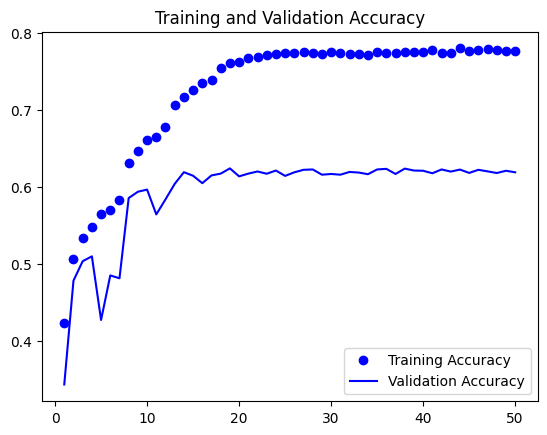

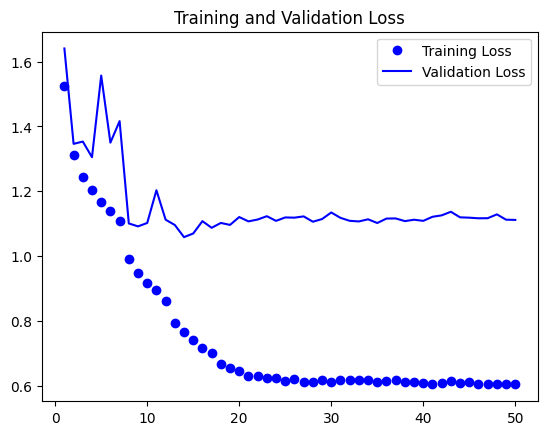

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label = "Training Accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = k.models.load_model("/content/drive/MyDrive/model/FER2013_best_model.keras")
test_loss, test_acc = test_model.evaluate(test_data)

113/113 [==============================] - 10s 18ms/step - loss: 0.9998 - accuracy: 0.6378


In [ ]:
test_pred = test_model.predict(test_data)

113/113 [==============================] - 2s 14ms/step


In [ ]:
print("Shape of all Predictions: " + str(test_pred.shape))
print("Sample prediction of first element: " + str(test_pred[0]))
test_pred = np.argmax(test_pred, axis = -1)
print("Shape after picking prediction label: " + str(test_pred.shape))
print("Sample prediction of first element after picking label: " + str(test_pred[0]))
test_true = np.argmax(test_img_labels, axis = -1)
print("Shape of all true label list: " + str(test_true.shape))
print("Sample prediction of first element in true label: " + str(test_true[0]))

Shape of all Predictions: (3589, 7)
Sample prediction of first element: [6.1697793e-01 4.2608655e-03 8.6818151e-02 2.0176591e-04 2.2090763e-01
 4.7037574e-03 6.6129848e-02]
Shape after picking prediction label: (3589,)
Sample prediction of first element after picking label: 0
Shape of all true label list: (3589,)
Sample prediction of first element in true label: 0


In [ ]:
#Evaluation
from sklearn.metrics import recall_score, precision_score

print("Micro F1 Score: " + str(f1_score(test_true, test_pred , average="micro")))
print("Weighted F1 Score: " + str(f1_score(test_true, test_pred , average="weighted")))
print("Recall Score: " + str(recall_score(test_true, test_pred, average='macro')))
print("Precision Score: " + str(precision_score(test_true, test_pred, average='macro')))


Micro F1 Score: 0.6377821120089161
Weighted F1 Score: 0.6358706349451246
Recall Score: 0.5856108794707564
Precision Score: 0.609717949459899


In [ ]:
###### ----------- ----- MODEL X - CNN ----------- ----- ######

In [ ]:
#Building CNN Architecture

inputsX = k.Input((48,48,3))
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu')(inputsX)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size = 2)(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size = 2)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size = 2)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
outputsX = tf.keras.layers.Dense(7, activation = 'softmax')(x)
modelX = k.Model(inputs = inputsX, outputs = outputsX)

modelX.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0     

In [ ]:
modelX.compile(loss = "categorical_crossentropy",
             optimizer = k.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
             metrics = ["accuracy"])

callbacks = [k.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/model/FER2013_best_modelX.keras",
                                         save_best_only=True,
                                         monitor='val_loss',
                                         mode='min'),
             k.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                           factor=0.3,
                                           patience=3,
                                           min_lr=0.000001,
                                           verbose=1,
                                           mode='auto')
]

In [ ]:
historyX = modelX.fit(train_data,
                   epochs = 50,
                   batch_size = 32,
                   validation_data = (val_data),
                   callbacks = callbacks)

print(historyX.history)

Epoch 1/50
808/808 [==============================] - 53s 55ms/step - loss: 1.7813 - accuracy: 0.3001 - val_loss: 1.8309 - val_accuracy: 0.2691 - lr: 0.0010
Epoch 2/50
808/808 [==============================] - 52s 64ms/step - loss: 1.5482 - accuracy: 0.3985 - val_loss: 1.4805 - val_accuracy: 0.4397 - lr: 0.0010
Epoch 3/50
808/808 [==============================] - 39s 49ms/step - loss: 1.4078 - accuracy: 0.4593 - val_loss: 1.3658 - val_accuracy: 0.4826 - lr: 0.0010
Epoch 4/50
808/808 [==============================] - 42s 51ms/step - loss: 1.3210 - accuracy: 0.4955 - val_loss: 1.3027 - val_accuracy: 0.5004 - lr: 0.0010
Epoch 5/50
808/808 [==============================] - 49s 61ms/step - loss: 1.2672 - accuracy: 0.5188 - val_loss: 1.2737 - val_accuracy: 0.5115 - lr: 0.0010
Epoch 6/50
808/808 [==============================] - 50s 62ms/step - loss: 1.2245 - accuracy: 0.5361 - val_loss: 1.1533 - val_accuracy: 0.5535 - lr: 0.0010
Epoch 7/50
808/808 [==============================] - 55s 

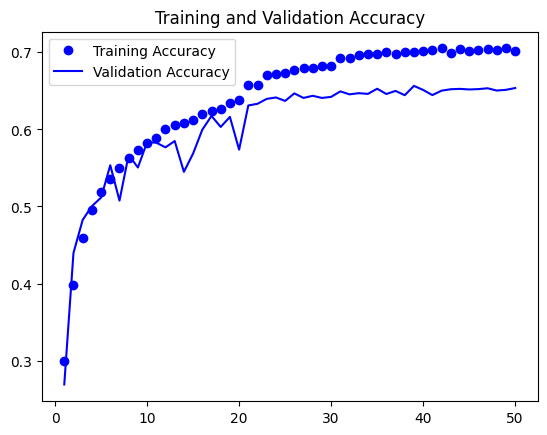

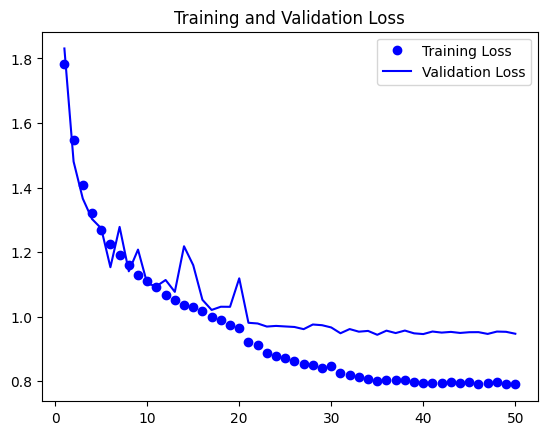

In [ ]:
acc = historyX.history["accuracy"]
val_acc = historyX.history["val_accuracy"]
loss = historyX.history["loss"]
val_loss = historyX.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label = "Training Accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_modelX = k.models.load_model("/content/drive/MyDrive/model/FER2013_best_modelX.keras")
test_lossX, test_accX = test_modelX.evaluate(test_data)

113/113 [==============================] - 2s 12ms/step - loss: 0.9264 - accuracy: 0.6640


In [ ]:
test_predX = test_model.predict(test_data)

113/113 [==============================] - 2s 14ms/step


In [ ]:
print("Shape of all Predictions: " + str(test_predX.shape))
print("Sample prediction of first element: " + str(test_predX[0]))
test_predX = np.argmax(test_predX, axis = -1)
print("Shape after picking prediction label: " + str(test_predX.shape))
print("Sample prediction of first element after picking label: " + str(test_predX[0]))
test_trueX = np.argmax(test_img_labels, axis = -1)
print("Shape of all true label list: " + str(test_trueX.shape))
print("Sample prediction of first element in true label: " + str(test_trueX[0]))

Shape of all Predictions: (3589, 7)
Sample prediction of first element: [6.1697793e-01 4.2608655e-03 8.6818151e-02 2.0176591e-04 2.2090763e-01
 4.7037574e-03 6.6129848e-02]
Shape after picking prediction label: (3589,)
Sample prediction of first element after picking label: 0
Shape of all true label list: (3589,)
Sample prediction of first element in true label: 0


In [ ]:

print("Micro F1 Score: " + str(f1_score(test_trueX, test_predX , average="micro")))
print("Weighted F1 Score: " + str(f1_score(test_trueX, test_predX , average="weighted")))
print("Recall Score: " + str(recall_score(test_trueX, test_predX, average='macro')))
print("Precision Score: " + str(precision_score(test_trueX, test_predX, average='macro')))



Micro F1 Score: 0.6377821120089161
Weighted F1 Score: 0.6358706349451246
Recall Score: 0.5856108794707564
Precision Score: 0.609717949459899


In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 16.7 MB/s eta 0:00:00


In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='/content/drive/MyDrive/model/model_architecture_rs_net2.jpeg', show_shapes=True, bgcolor='white', node_shape='box')



import visualkeras
from PIL import ImageFont




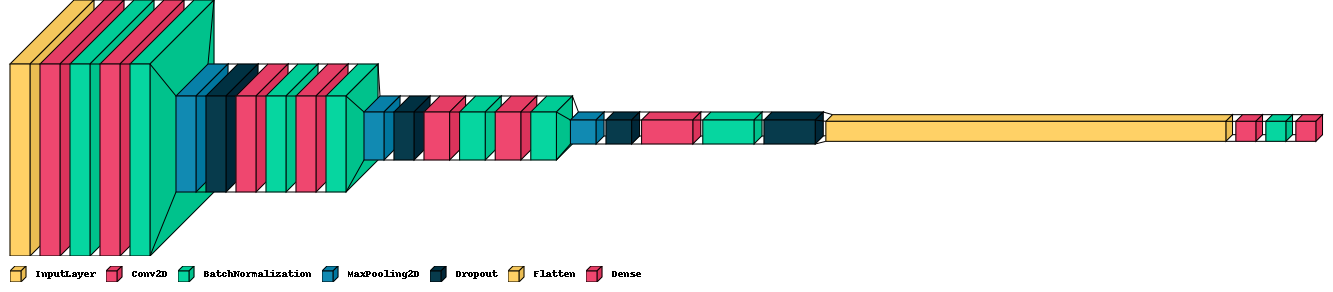

In [ ]:
visualkeras.layered_view(modelX,to_file='/content/drive/MyDrive/model/model_architecture_cnn.png',legend=True)

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 30.1 MB/s eta 0:00:00
